# **Import Libraries**

In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# **Define Directries**

In [2]:
train_dir = 'hymenoptera_data/train'
val_dir = 'hymenoptera_data/val'

# **Create dataframe class**

In [3]:
class dataFrame():
    def __init__(self,dir):
        self.dir = dir
    
    def create_dataframe(self):
        filesanmes = []
        categories = []
        for classnames in os.listdir(self.dir):
                train_class_path = os.path.join(self.dir,classnames)
                for filesname in os.listdir(train_class_path):
                    filesanmes.append(filesname)
                    categories.append(classnames)
        df = pd.DataFrame({'Filenmae':filesanmes,'Category':categories})
        return df

# **Create dataframes**

In [4]:
traing_obj = dataFrame(train_dir)
training_df = traing_obj.create_dataframe()

val_obj = dataFrame(val_dir)
val_df = val_obj.create_dataframe()

# **View Dataframes**

In [5]:
val_df

Filenmae Category
0                         10308379_1b6c72e180.jpg     ants
1                       1053149811_f62a3410d3.jpg     ants
2                       1073564163_225a64f170.jpg     ants
3                       1119630822_cd325ea21a.jpg     ants
4                       1124525276_816a07c17f.jpg     ants
..                                            ...      ...
148  6a00d8341c630a53ef00e553d0beb18834-800wi.jpg     bees
149                       72100438_73de9f17af.jpg     bees
150                      759745145_e8bc776ec8.jpg     bees
151                      936182217_c4caa5222d.jpg     bees
152                                     abeja.jpg     bees

[153 rows x 2 columns]

# **Display the images using dataframe**

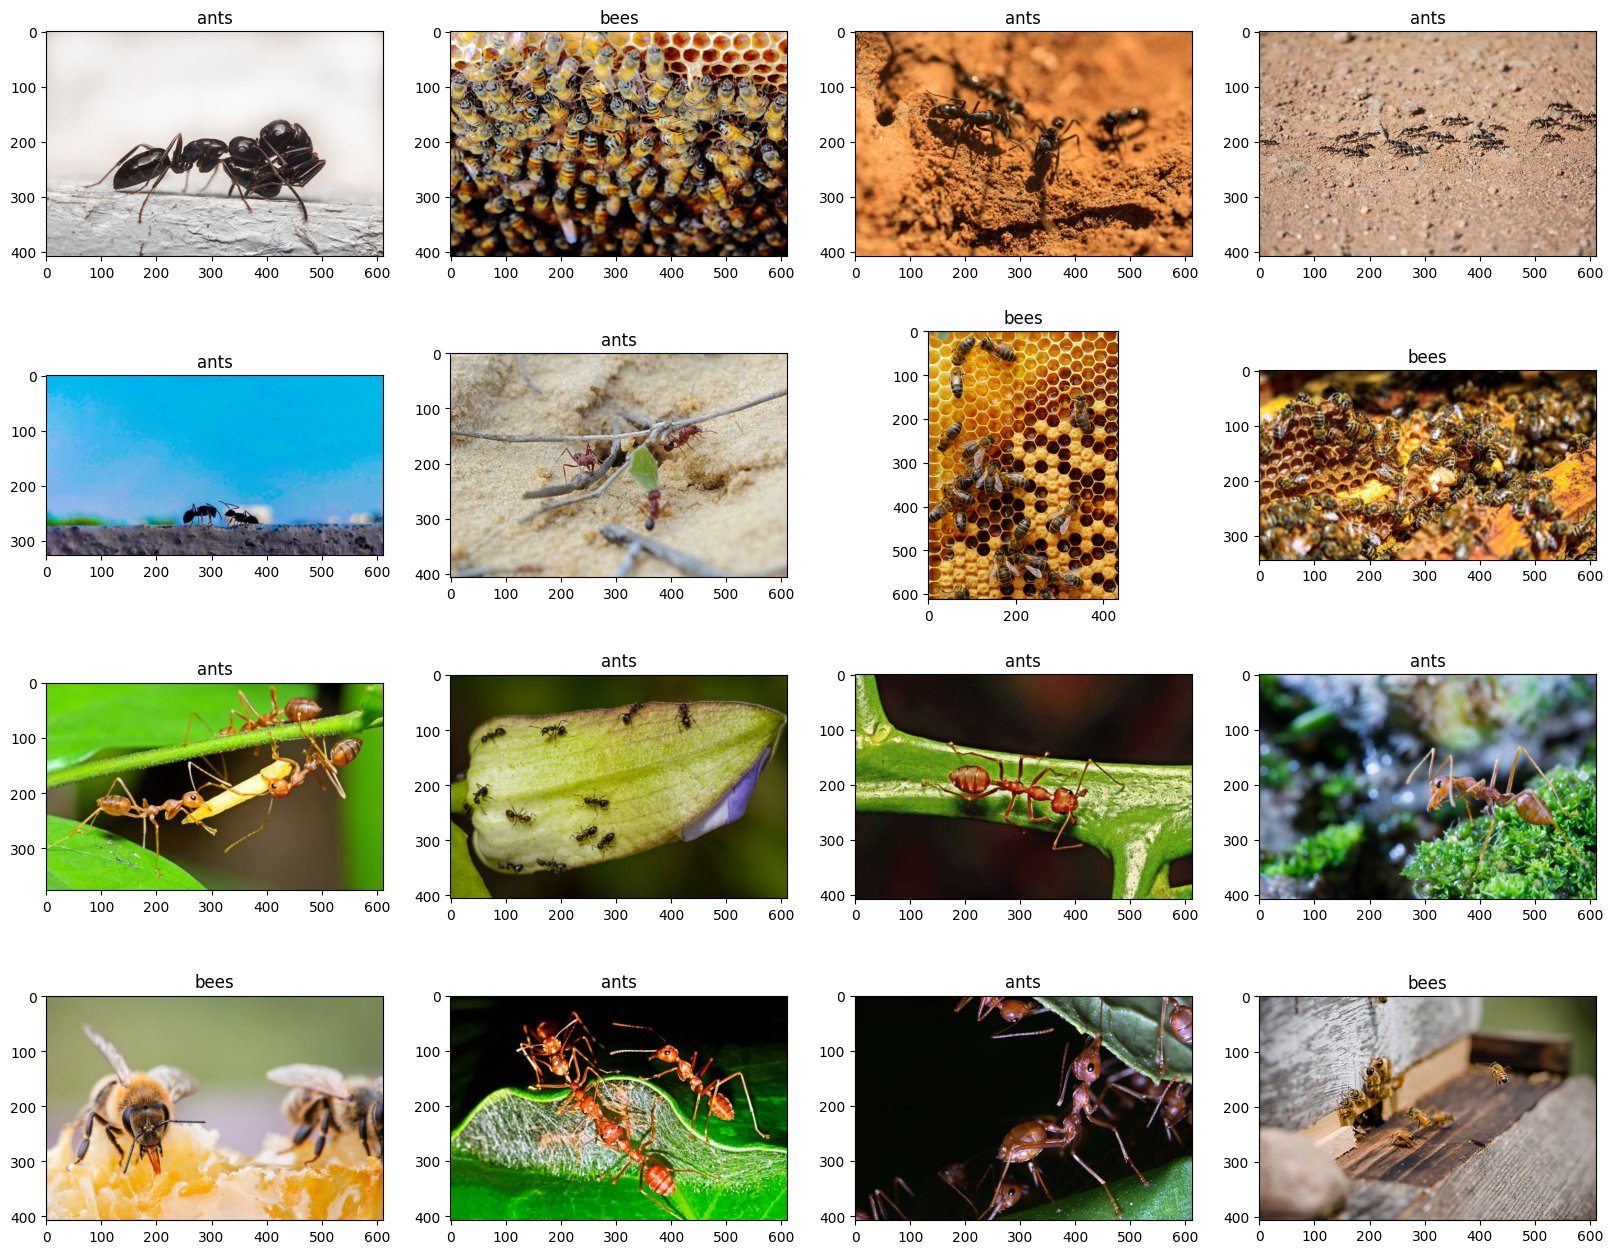

In [6]:
fig,ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.ravel()

for i in range(16):
    sample_row = training_df.sample(n = 1).iloc[0]
    img_path = os.path.join(train_dir,sample_row['Category'],sample_row['Filenmae'])
    img = Image.open(img_path)
    ax[i].imshow(img)
    ax[i].set_title(sample_row['Category'])

plt.show()

# **Transfroms**

In [7]:
transformation = transforms.Compose([
    transforms.Resize((60,60)),
    transforms.ToTensor()
])

# **Create the datasets class**

In [8]:
class Dataset():
    def __init__(self, dir, df, transforms=None):
        self.dir = dir
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.dir,self.df.iloc[idx]['Category'],self.df.iloc[idx]['Filenmae'])
        img = Image.open(img_path)
        
        if self.df.iloc[idx]['Category'] == 'ants':
            label = 1
        else:
            label = 0
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return (img, label)

# **Create train, val and test ojects**

In [9]:
train = Dataset(train_dir, training_df, transformation)
val = Dataset(val_dir, val_df, transformation)

# **Get the length**

In [10]:
print(len(train))
print(len(val))

2164
153


# **Plot bar graph**

<Axes: >

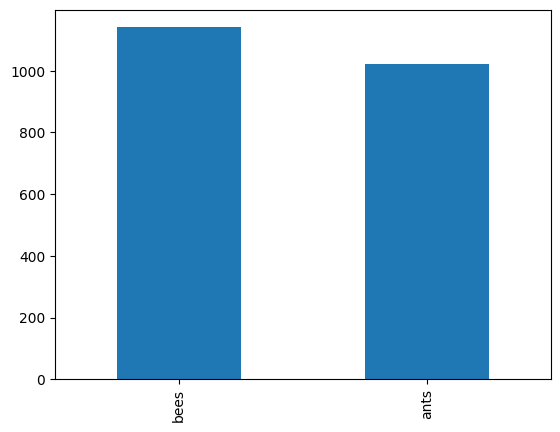

In [11]:
training_df['Category'].value_counts().plot(kind='bar')

# **Create the datsets**

In [12]:
train_datasets = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_datasets = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

# **Get the length**

In [13]:
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])


In [14]:
print(len(train_datasets))
print(len(val_datasets))

68
5


# **Plot the images**

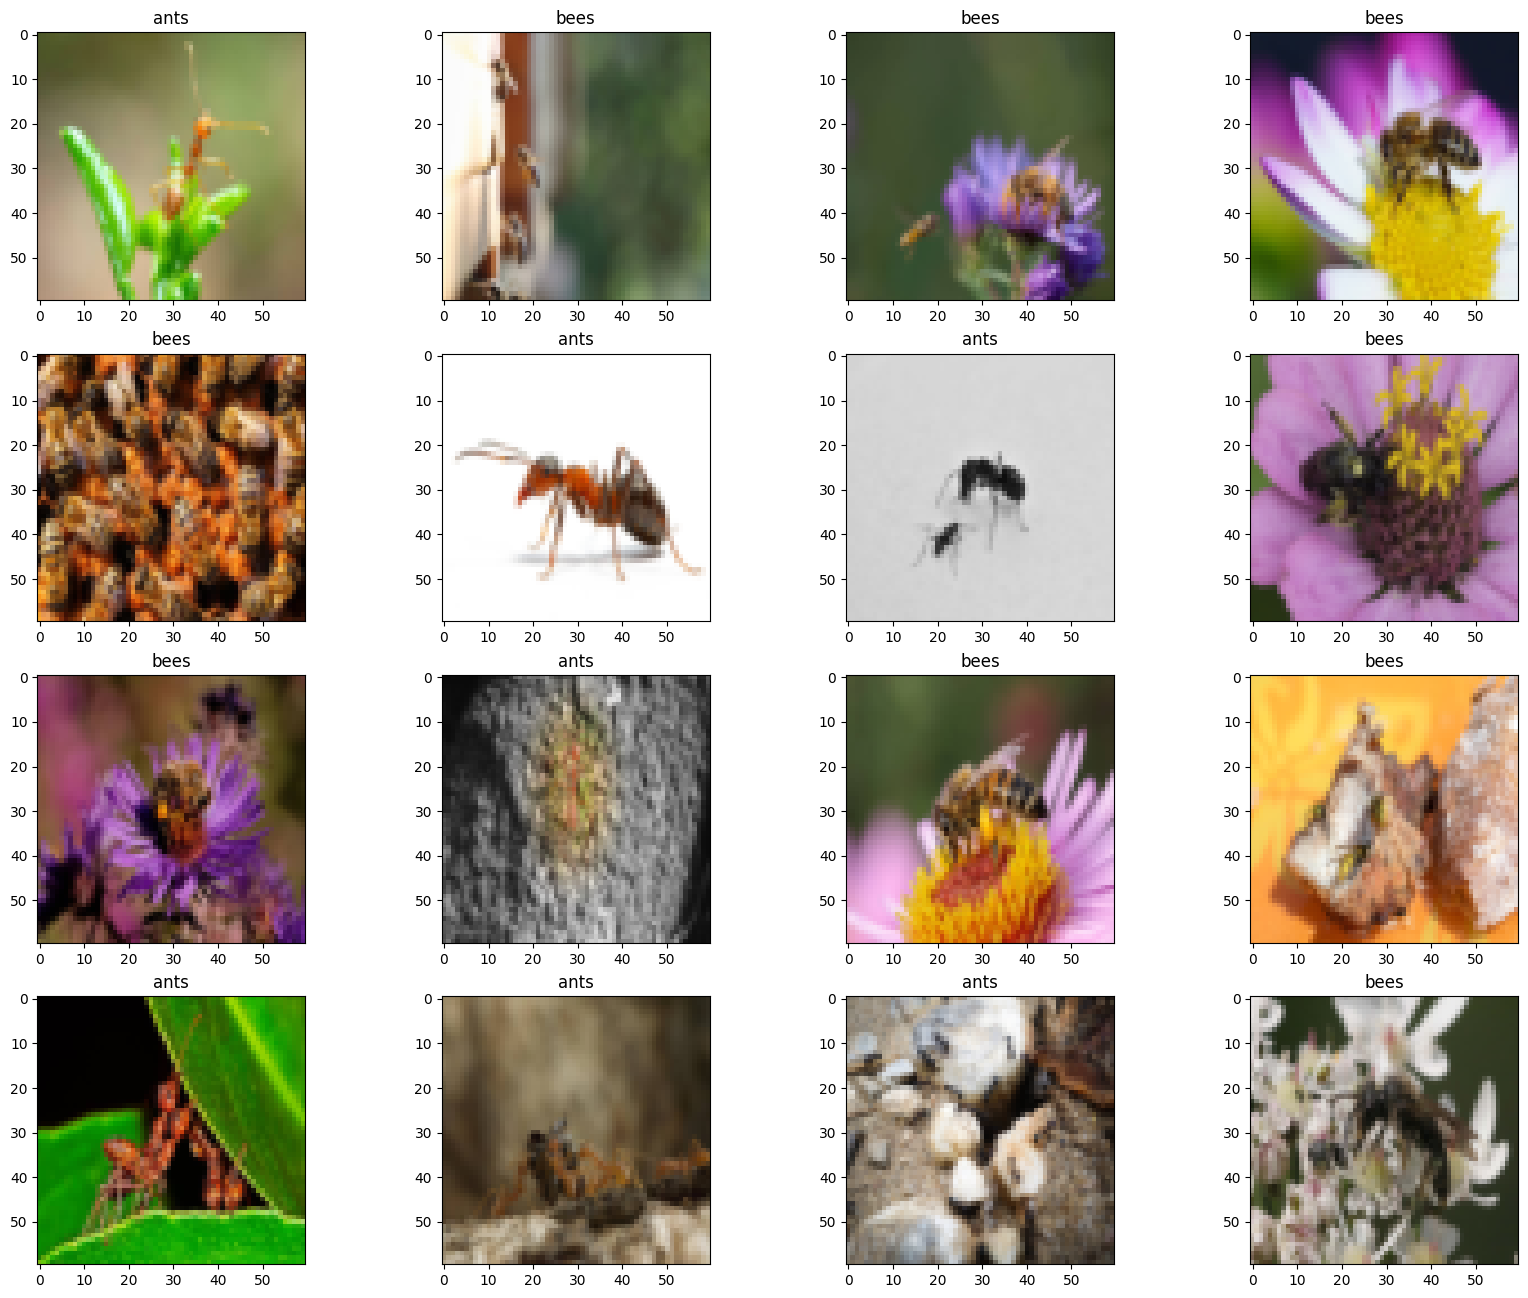

In [15]:
samples,labels = next(iter(train_datasets))

fig, axes = plt.subplots(4,4,figsize=(20,16))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(samples[i].permute(1,2,0))  ## (C,H,W) to (H,W,C)
    if labels[i].item() == 1:
        axes[i].set_title('ants')
    else:
        axes[i].set_title('bees')

# **Create the CNN model**

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) # (60 + 2 *0 -3 / 1) + 1 = 58*58*16
        self.pool1 = nn.MaxPool2d(2) # (58 + 2 *0 -2 / 2) + 1 = 29*29*16
        
        self.conv2 = nn.Conv2d(16, 32, 3) # (29 + 2 *0 -3 / 1) + 1 = 27*27*32
        self.pool2 = nn.MaxPool2d(2) # (27 + 2 *0 -2 / 2) + 1 = 13*13*32
        
        self.conv3 = nn.Conv2d(32, 64, 3) # (13 + 2 *0 -3 / 1) + 1 = 11*11*64
        self.pool3 = nn.MaxPool2d(2)   # (11 + 2 *0 -2 / 2) + 1 = 5*5*64
        
        self.flatten = nn.Flatten() # 5*5*64 = 1600
        
        self.fc1 = nn.Linear(64*5*5,256)    
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,2)
        
        self.softmax = nn.Softmax(dim=1) # Ne1 = 0.2, Ne2 = 0.8 ==> 1
    
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
         
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

model = CNN().to(device)

# **Get the model summary**

In [17]:
from torchsummary import summary
summary(model, (3,60,60)) # (C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
         MaxPool2d-2           [-1, 16, 29, 29]               0
            Conv2d-3           [-1, 32, 27, 27]           4,640
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
         MaxPool2d-6             [-1, 64, 5, 5]               0
           Flatten-7                 [-1, 1600]               0
            Linear-8                  [-1, 256]         409,856
            Linear-9                  [-1, 128]          32,896
           Linear-10                    [-1, 2]             258
          Softmax-11                    [-1, 2]               0
Total params: 466,594
Trainable params: 466,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/

# **Define optimizers**

In [18]:
criterian = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 50

# **Define model training**

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    correct = 0
    train_running_loss = 0.0
    
    for data,labels in train_datasets:
        data,labels = data.to(device), labels.to(device)
        optimizer.zero_grad() ## convert the gradient values into zero for each batch 
        output = model(data) 
        loss = criterian(output, labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
        _,pred = torch.max(output,1)
        
        correct += (pred == labels).sum().item()
    
    train_accuracy.append(100 * correct / len(train))
    train_loss.append(train_running_loss / len(train_datasets))
    print(f'Epoch: {epoch+1} Training Loss: {train_running_loss / len(train_datasets)} Training Accuracy: {100 * correct / len(train)}')
    
    with torch.no_grad():
        model.eval()
        correct = 0
        val_running_loss = 0.0
        for val_data, val_labels in val_datasets:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_output = model(val_data)
            val_loss_value = criterian(val_output, val_labels)
            
            val_running_loss += val_loss_value.item()
            _,val_pred = torch.max(val_output,1)
            correct += (val_pred == val_labels).sum().item()
        
        val_accuracy.append(100 * correct / len(val))
        val_loss.append(val_running_loss / len(val_datasets))
        
        print(f'Epoch: {epoch+1} Validation Loss: {val_running_loss / len(val_datasets)} Validation Accuracy: {100 * correct / len(val)}')

Epoch: 1 Training Loss: 0.6460944878704408 Training Accuracy: 60.12014787430684
Epoch: 1 Validation Loss: 0.659721028804779 Validation Accuracy: 59.47712418300654
Epoch: 2 Training Loss: 0.5997443124651909 Training Accuracy: 68.99260628465804
Epoch: 2 Validation Loss: 0.6324523568153382 Validation Accuracy: 59.47712418300654
Epoch: 3 Training Loss: 0.5509265376364484 Training Accuracy: 73.98336414048059
Epoch: 3 Validation Loss: 0.6004518628120422 Validation Accuracy: 67.97385620915033
Epoch: 4 Training Loss: 0.5117858394103891 Training Accuracy: 79.25138632162661
Epoch: 4 Validation Loss: 0.5929467558860779 Validation Accuracy: 70.58823529411765
Epoch: 5 Training Loss: 0.5033238731762942 Training Accuracy: 80.0369685767098
Epoch: 5 Validation Loss: 0.6030180931091309 Validation Accuracy: 71.89542483660131
Epoch: 6 Training Loss: 0.5034065702382255 Training Accuracy: 80.49907578558225
Epoch: 6 Validation Loss: 0.6342887163162232 Validation Accuracy: 65.359477124183
Epoch: 7 Training Lo

# **Plot the graph**

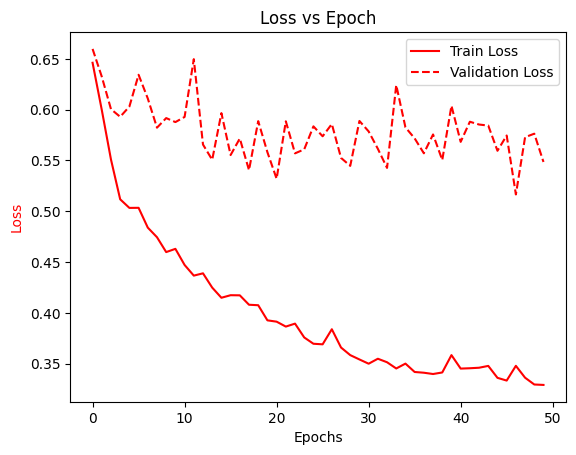

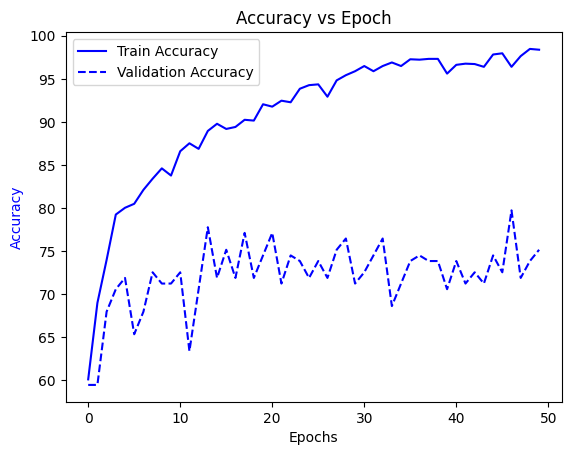

In [20]:
epoch_log = [*range(epochs)]

fig,ax1 = plt.subplots()
ax1.plot(epoch_log,train_loss,'r-',label = 'Train Loss')
ax1.plot(epoch_log,val_loss,'r--',label = 'Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='r')
ax1.set_title('Loss vs Epoch')
ax1.legend()
plt.show()

fig,ax2 = plt.subplots()
ax2.plot(epoch_log,train_accuracy,'b-',label = 'Train Accuracy')
ax2.plot(epoch_log,val_accuracy,'b--',label = 'Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy',color='b')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
plt.show()

# **Save the model**

In [21]:
path = 'aunt_vs_bee.pth'
torch.save(model,path)

# **Load the model**

In [22]:
model = torch.load(path)

# **Plot the images**

In [23]:
data,labels = next(iter(train_datasets))

print(data.shape)

torch.Size([32, 3, 60, 60])


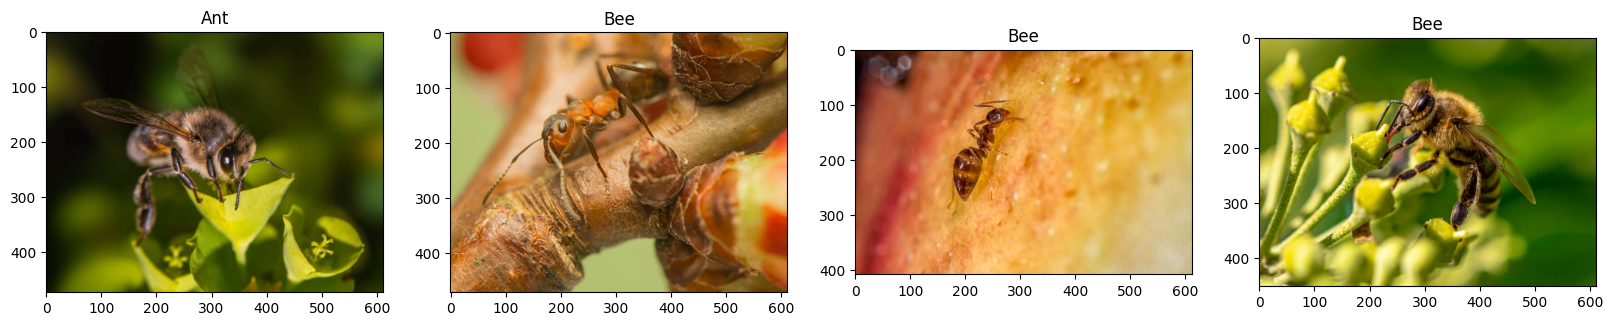

In [26]:
import random

test_filenames = os.listdir('hymenoptera_data/test')

images = []
def preprocessing(image):
    img = transformation(image) ##  (c,h,w) required == (b,c,h,w) ==> (1,3,60,60)
    img = img.unsqueeze(0)
    return img

fig, axes = plt.subplots(1,4,figsize=(20,16))
axes = axes.ravel()
class_names = {0:'Bee', 1:'Ant'}

for i in range(0,4):
    img_path = 'hymenoptera_data/test/' + random.choice(test_filenames)
    image = Image.open(img_path)
    preprocessed_img = preprocessing(image)
    
    output = model(preprocessed_img.to(device))
    pred = torch.argmax(output).item()
    label = class_names[pred]
    axes[i].imshow(image)
    axes[i].set_title(label)

plt.show()
    